## 회고
### 인물모드 사진을 제작
- 아웃포커싱 효과가 적용된  인물모드 사진, 고양이사진 그리고 배경 전환이 들어간 크로마키 사진을 제작하였습니다.

### 제작한 인물모드 사진들에서 나타나는 문제점
1. 손이 앞에 있는사진에서 손을 인식하지 못했음
2. 놀이터에서 놀이기구를 타는 사진에서는 옷과 놀이기구를 잘 구별하지 못함. 구석에도 놀이기구가 사람으로 인식이 되기도함
3. 확실히 배경이 멀리 있는 사진들에서는 인물이 잘 나뉘었음

### 가우시안 Blur나 3D Depth로 문제를 해결한다
- 가우시안 Blur를 사용하면 저희 모델의 Semantic Segmentation이 만들어낸 mask 영역을 매끄럽게 적용할 수 있다. 또한,
현재의 2차원 depth에서 3차원 depth를 활용하는 모델을 사용하면 mask영역을 더 매끄럽게 탐지할 수 있다.

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [30]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image1.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(936, 736, 3)


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다.
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input

    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [19]:
def model_run(img_orig, label=15):
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())

    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label, label, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 배경 흐리게 하기
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다.
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    # 흐린 배경과 원본 영상 합성
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

(936, 736, 3) (513, 403, 3) 15


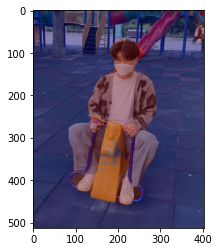

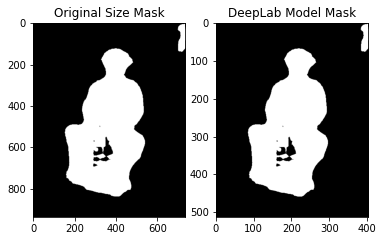

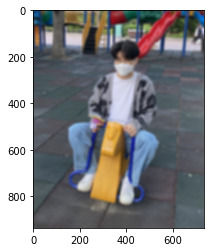

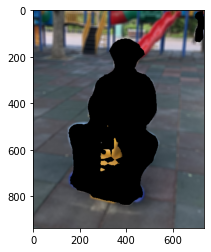

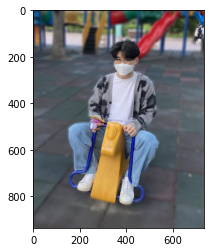

In [7]:
model_run(img_orig)

In [29]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(1280, 960, 3)


(1280, 960, 3) (513, 384, 3) 15


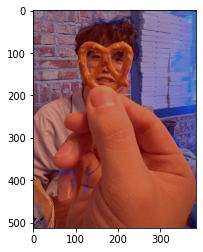

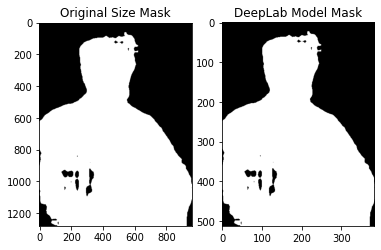

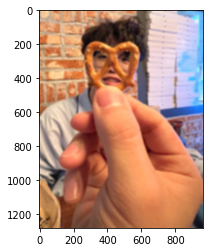

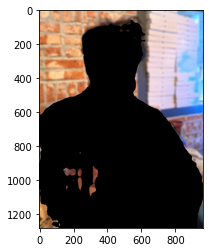

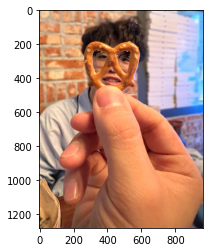

In [9]:
model_run(img_orig)

In [10]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(943, 895, 3)


(943, 895, 3) (513, 486, 3) 15


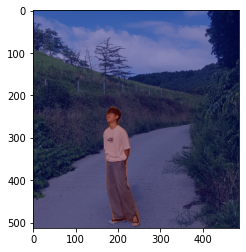

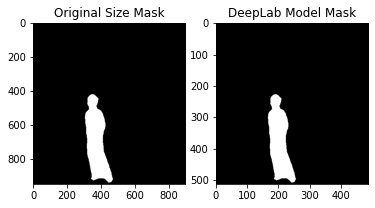

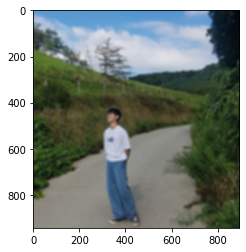

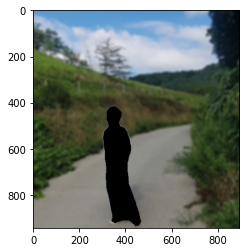

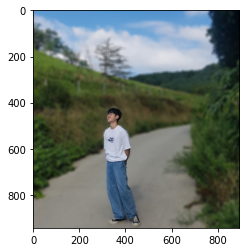

In [11]:
model_run(img_orig)

In [12]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Origins-of-cats.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(600, 1200, 3)


(600, 1200, 3) (256, 513, 3) 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


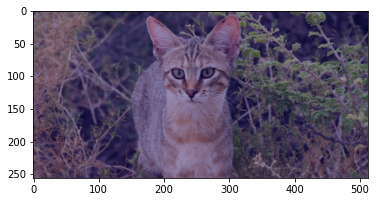

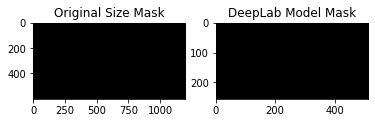

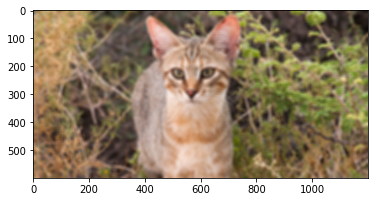

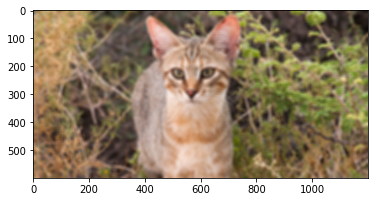

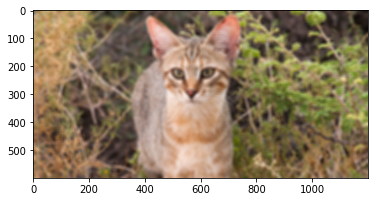

In [13]:
model_run(img_orig)

배경이 비슷해서 고양이가 제대로 나오지 않았다.

In [14]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/before-800x450.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(450, 800, 3)


(450, 800, 3) (288, 513, 3) 8


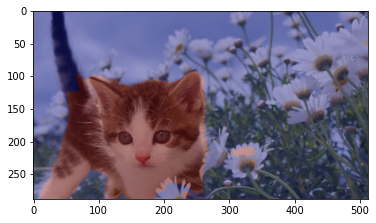

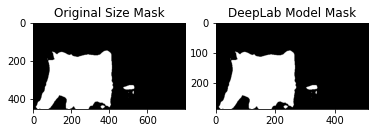

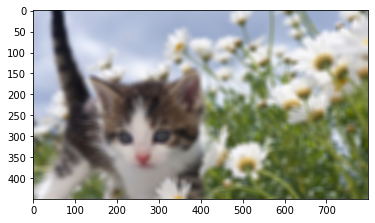

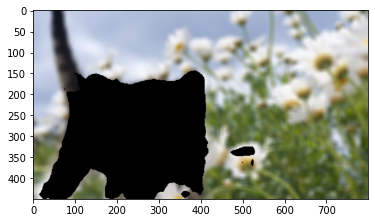

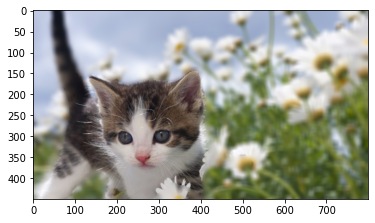

In [20]:
model_run(img_orig, label=8)

In [59]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/190710_uyuni01.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
background = cv2.imread(img_path)

In [67]:
img_orig.shape[:2]

(936, 736)

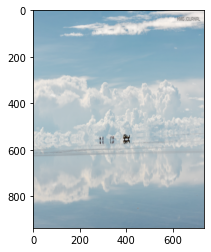

In [68]:
background = cv2.resize(background, (736, 936), interpolation = cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
def model_run(img_orig, label=15):
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())

    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label, label, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 배경 흐리게 하기
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다.
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    # 흐린 배경과 원본 영상 합성
    img_concat = np.where(img_mask_color==255, img_orig, background)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

In [37]:
from PIL import Image

In [36]:
img_orig.shape

(936, 736, 3)

(936, 736, 3) (513, 403, 3) 15


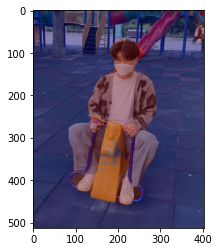

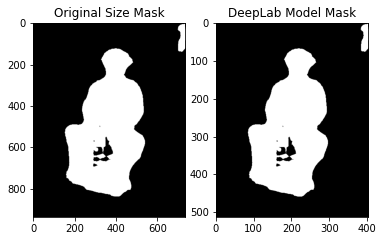

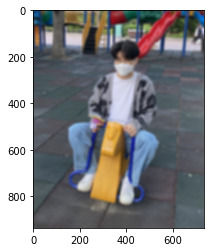

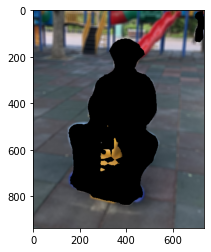

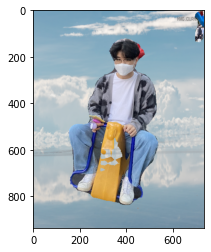

In [70]:
model_run(img_orig)
